In [1]:
import pandas as pd
import matplotlib.image as mpimg
import os
import matplotlib.lines as mlines
from matplotlib.colors import Normalize
import numpy as np

def convert_coordinates(df):
    x_min, y_min = df['x'].min(), df['y'].min()
    interval_length_x = df['x'].drop_duplicates().sort_values().diff().value_counts().idxmax()
    interval_length_y = df['y'].drop_duplicates().sort_values().diff().value_counts().idxmax()

    df_converted = df.copy()
    df_converted['x'] = ((df_converted['x'] - x_min) / interval_length_x).round().astype(int)
    df_converted['y'] = ((df_converted['y'] - y_min) / interval_length_y).round().astype(int)
    return df_converted

def create_intensity_image(df_intensity, df_coordinates, mz_value, scale_factor=0.1,
                          norm=True,denoise=False, smooth=False, smooth_method='gaussian', kernel_size=5):
    
    # Extracting intensity values for the specified m/z
    intensities = df_intensity[df_intensity.iloc[:,0] == mz_value].iloc[0, 1:]

    # Scaling down the coordinates
    df_coordinates_scaled = df_coordinates.copy()
    df_coordinates_scaled['x'] = (df_coordinates_scaled['x'] * scale_factor).astype(int)
    df_coordinates_scaled['y'] = (df_coordinates_scaled['y'] * scale_factor).astype(int)

    # Creating a blank image with dimensions based on the max coordinates
    max_x, max_y = df_coordinates_scaled['x'].max(), df_coordinates_scaled['y'].max()
    image = np.zeros((max_y + 1, max_x + 1))

    # Mapping each spot's intensity to its coordinates in the image
    for spot, intensity in intensities.items():
        spot_number = int(spot.split(' ')[1])
        x, y = df_coordinates_scaled[df_coordinates_scaled['Spot'] == spot_number][['x', 'y']].iloc[0]
        image[y, x] = intensity
    
    #norm = Normalize(vmin=image.min(), vmax=image.max())
    if norm:
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    if image.dtype != np.uint8:
        image = (255 * image).astype(np.uint8)
    if denoise:
        image = cv2.fastNlMeansDenoising(image, None)

    # Smooth the image
    if smooth:
        if smooth_method == 'gaussian':
            image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        elif smooth_method == 'median':
            image = cv2.medianBlur(image, kernel_size)

    return image
def find_closest_mz_name(mz_value, df_feature_list):
    # Find the closest m/z value
    closest_match = df_feature_list.iloc[(df_feature_list['m/z'] - mz_value).abs().argsort()[:1]]
    return closest_match['Name'].values[0]
def plot_pc_intensity(df_intensity,df_coordinates,out_dir=None):
    
    
    #out_dir = os.path.join(parent_dir,'constructedImages')
    #os.makedirs(out_dir, exist_ok=True)

    scale_bar_micrometers = 100
    scale_bar_pixels = scale_bar_micrometers / 20  # Convert to pixels (each pixel is 20 micrometers)


    

    # Renaming columns in df_coordinates for clarity
    df_coordinates.columns = ['Spot', 'x', 'y']
    #!!!!!mismatch between the 2 df(regions start from spot 0, intensities start from spot 1)
    df_coordinates['Spot'] = df_coordinates['Spot']+1

    #select only the spots used in df_intensities
    spot_numbers = [int(col.split(' ')[1]) for col in df_intensity.columns if 'Spot' in col]
    selected_coordinates = df_coordinates[df_coordinates['Spot'].isin(spot_numbers)]
    #print(selected_coordinates.head(5))

    #convert from micro to pixel
    df_converted_coordinates = convert_coordinates(selected_coordinates)
    # Directory for saving images
    #output_dir = '/path/to/output/directory'
    #os.makedirs(output_dir, exist_ok=True)

    


    for idx, pc in enumerate(df_intensity.iloc[:5,0]):
    #     fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(36, 36))
    #     ax1 = axes[idx,0]
        fig, ax1 = plt.subplots(figsize=(10, 10))
        # Generate the image
        
        image = create_intensity_image(df_intensity, df_converted_coordinates, pc, 1)


        cax = ax1.imshow(np.flipud(image), cmap='jet')#flip upside down
        #ax1.set_title(f'{mz_value} -{mz_name}- reconstructed')
        ax1.axis('off')  # Turn off axis
        fig.colorbar(cax, ax=ax1, orientation='vertical',shrink=.78,aspect=20)

    #     thres = (80,90,95)
    #     overlaid_image_list= getIntContour(image,thres)
    #     for j in range(1,4):
    #         ax = axes[idx,j]
    #         cax = ax.imshow(np.flipud(overlaid_image_list[j]))#flip upside down
    #         ax.set_title(f'{thres[j]}- percentile contour')
    #         ax.axis('off') 
        bar_x_position = 3
        bar_y_position = image.shape[0] - 4
        line = mlines.Line2D([bar_x_position, bar_x_position + scale_bar_pixels], 
                             [bar_y_position, bar_y_position], 
                             color='white', linewidth=2)
        ax1.add_line(line)

        # Add text label for the scale bar below the line
        ax1.text(bar_x_position, bar_y_position + 2, f'{scale_bar_micrometers} μm', 
                color='white', fontsize=10, verticalalignment='bottom')


        #plt.tight_layout()
        if out_dir != None:
            out_file_path = os.path.join(out_dir,f'{pc}_coefficient.png')
            fig.savefig(out_file_path)
        plt.show()
        plt.close(fig)
        print(f'{pc} done')




def plot_bar(weight_df,df_feature_list,col='PC1',num=10,out_dir=None):

    # Sort by PC1 and select the top and bottom 10
    top_10 = weight_df.nlargest(num, col)
    bottom_10 = weight_df.nsmallest(num, col)

    # Combine top and bottom into one DataFrame and sort
    selected_molecules = pd.concat([top_10, bottom_10]).sort_values(by=col)

    # Replace m/z with mz_name
    selected_molecules['mz_name'] = [find_closest_mz_name(mz, df_feature_list) for mz in selected_molecules['m/z']]

    # Plotting
    plt.figure(figsize=(12, 6))
    x_positions = range(1, len(selected_molecules) + 1)

    for x, row in zip(x_positions, selected_molecules.itertuples()):
        color = 'red' if getattr(row, col) > 0 else 'blue'
        plt.bar(x, getattr(row, col), color=color)

    plt.xticks(x_positions, selected_molecules['mz_name'], rotation=45, ha='right')
    plt.gca().spines['bottom'].set_visible(False)

    plt.xlabel('Molecule Name')
    plt.ylabel(f'{col} Value')
    plt.title(f'Top and Bottom 10 Molecules on {col}')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    if out_dir != None:
        plt.savefig(os.path.join(out_dir,f'bar_{col}_top{num}.png'))
    plt.show()
    


In [248]:
import pandas as pd
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def main(parent_dir,file_intensity,file_coordinates,feature_list_path):
    skip_rows_intensity = 10  # This number may need to be adjusted based on the actual file content
    df_intensity = pd.read_csv(file_intensity, skiprows=skip_rows_intensity, header=0, delimiter=';')

    df_feature_list = pd.read_csv(feature_list_path, delimiter=';', skiprows=8)
    df_coordinates = pd.read_csv(file_coordinates, skiprows=8, delimiter=';')
    ###########PCA
    X = df_intensity.iloc[:, 1:]  
    
    X = X.T#m*n,2000*57
    #print(X.shape)

    # Standardizing the features(per molecule)
    
    X_standardized = StandardScaler().fit_transform(X)

    # Performing PCA
    pca = PCA(n_components=50)
    principal_components = pca.fit_transform(X_standardized)
    #m*p,2000*8
    
    # Creating a DataFrame with the principal components
    pc_intensities = pd.DataFrame(data=principal_components,
                          columns=[f'PC{i}' for i in range(1,51)])
    
    
    

    # Concatenating the molecule names ('m/z') with the principal components
    #Ax=b, x=A^(-1)*b of dimension n*p
    weight_df = pd.DataFrame(data=np.linalg.pinv(X_standardized).dot(principal_components),
                          columns=[f'PC{i}' for i in range(1,51)])
    weight_df = pd.concat([df_intensity['m/z'], weight_df], axis=1)

    
    

    ######
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    out_dir = os.path.join(parent_dir,'PCA_fig')
    os.makedirs(out_dir,exist_ok=True)
  
    plt.plot(range(1,51),pca.explained_variance_ratio_)
    plt.savefig(os.path.join(out_dir,'elbow_curve.png'))
    
    plot_bar(weight_df,df_feature_list,col='PC1',num=10,out_dir=out_dir)
    plot_bar(weight_df,df_feature_list,col='PC2',num=10,out_dir=out_dir)
    plot_bar(weight_df,df_feature_list,col='PC3',num=10,out_dir=out_dir)
    plot_bar(weight_df,df_feature_list,col='PC4',num=10,out_dir=out_dir)
    plot_bar(weight_df,df_feature_list,col='PC5',num=10,out_dir=out_dir)
    
    pc_intensities_t = pc_intensities.T.reset_index()
    pc_intensities_t.columns = df_intensity.columns#To adapt to the intensity _col format
    plot_pc_intensity(pc_intensities_t,df_coordinates,out_dir)
  

In [166]:
principal_components.shape

(57, 50)

In [210]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df_intensity = pd.read_csv(file_intensity, skiprows=skip_rows_intensity, header=0, delimiter=';')

df_feature_list = pd.read_csv(feature_list_path, delimiter=';', skiprows=8)
df_coordinates = pd.read_csv(file_coordinates, skiprows=8, delimiter=';')

[0.2463318  0.04500898 0.02274972 0.02051398 0.02012059 0.01962051
 0.01931759 0.01887942 0.01870817 0.01844043 0.01821802 0.01806176
 0.01772345 0.01755349 0.01728468 0.01719336 0.01714907 0.01688839
 0.01671468 0.01656773 0.01631411 0.01614771 0.01589334 0.01574192
 0.01551605 0.01525718 0.01508422 0.01489508 0.0147672  0.01425963
 0.01409711 0.01388478 0.01378155 0.013118   0.01300693 0.01258441
 0.01240002 0.01203753 0.01148166 0.01102353 0.01080895 0.00966807
 0.00911542 0.00860568 0.00825736 0.00815551 0.0076253  0.00601558
 0.00551407 0.00485053]
0.9829542448618372


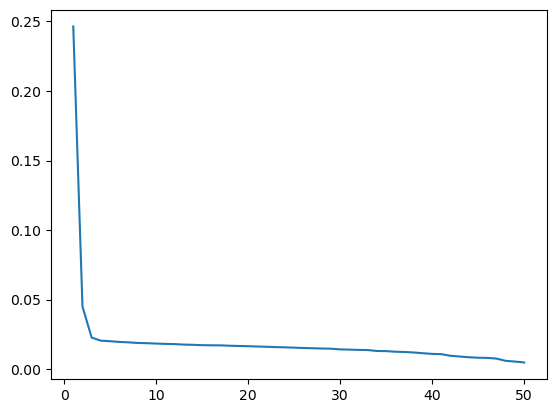

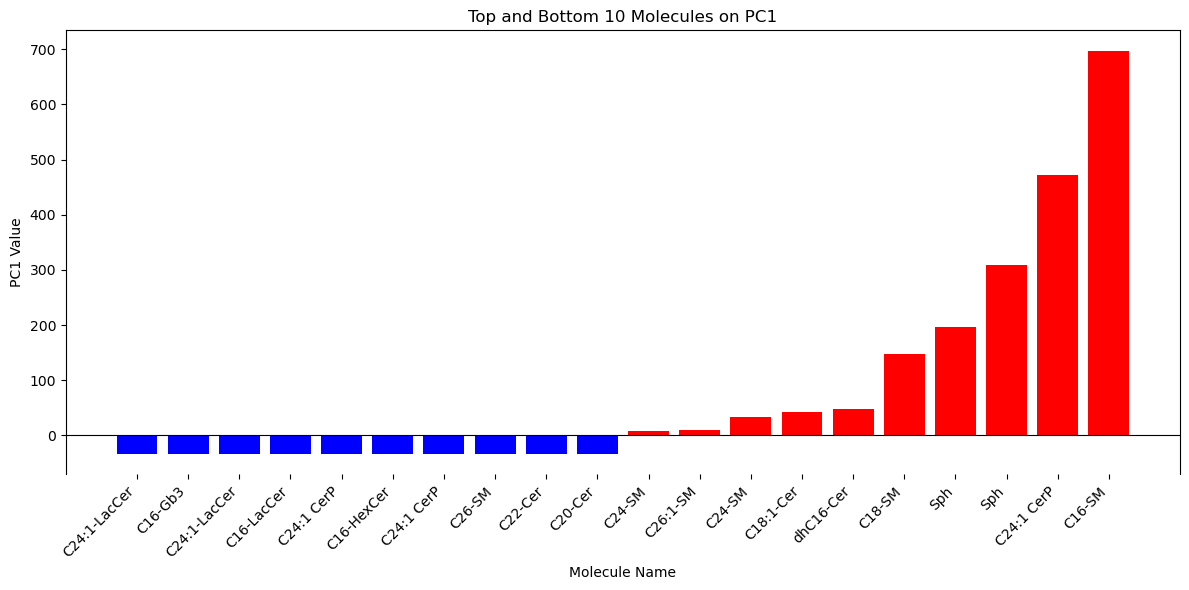

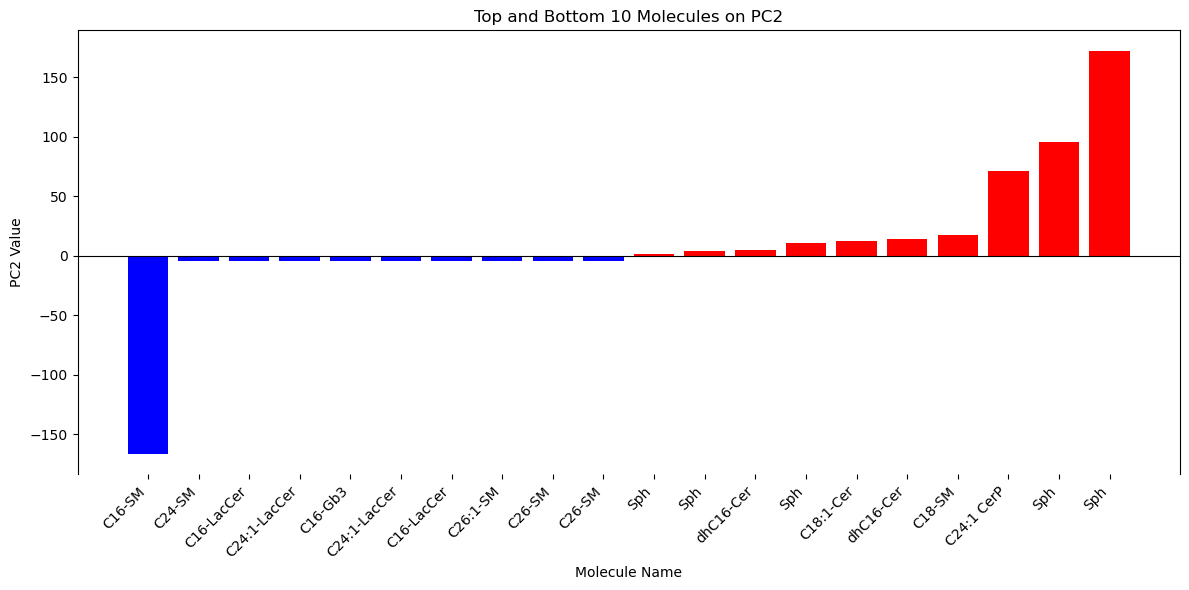

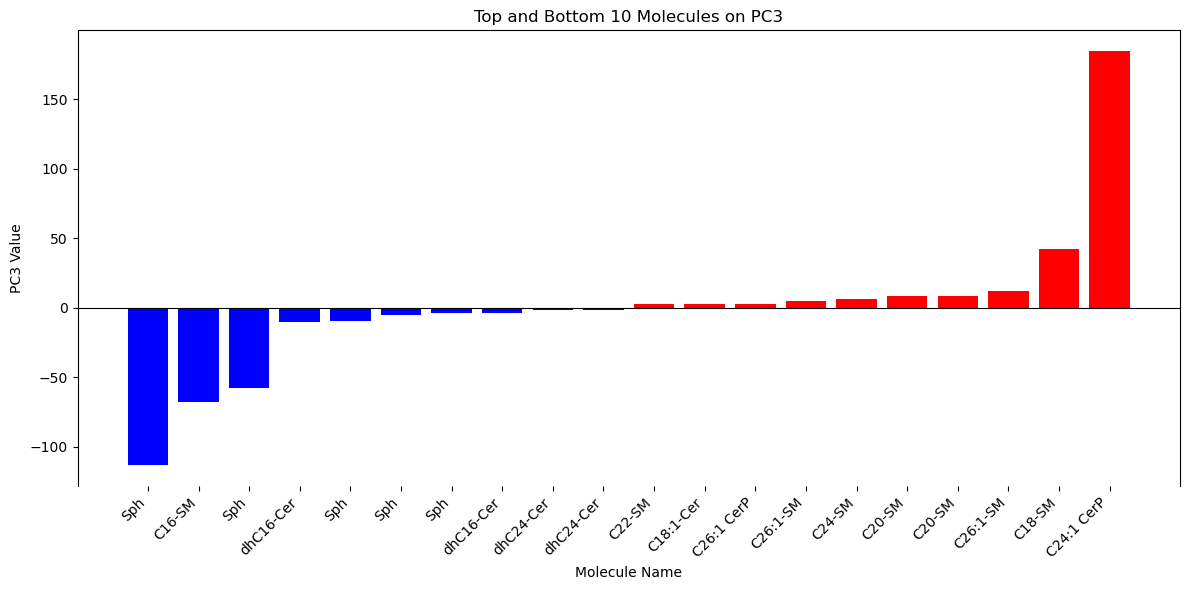

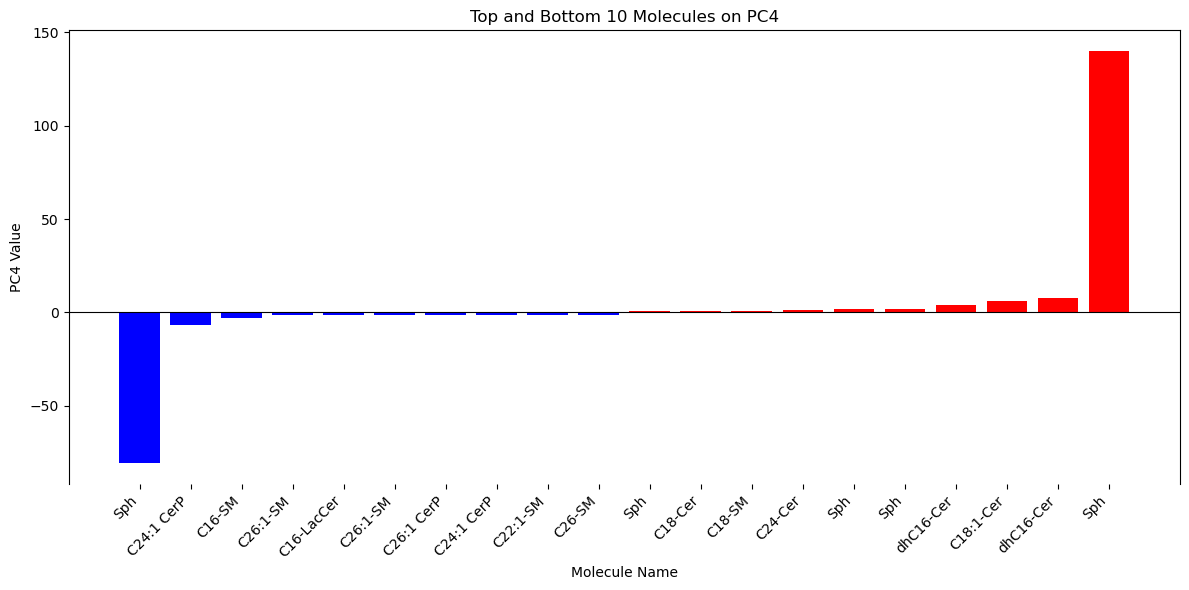

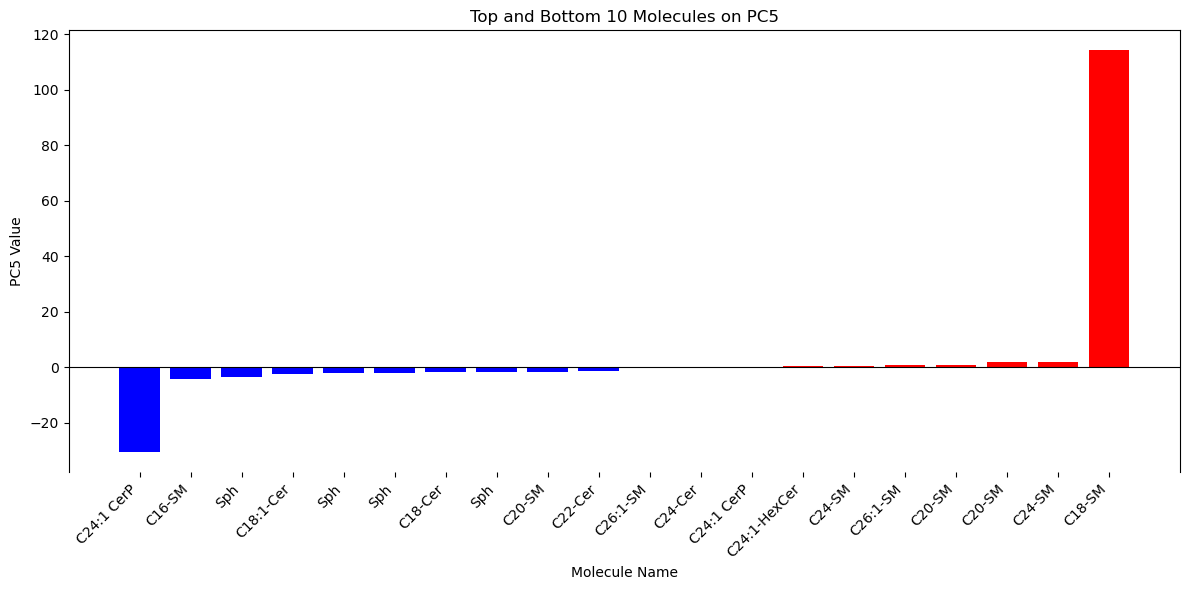

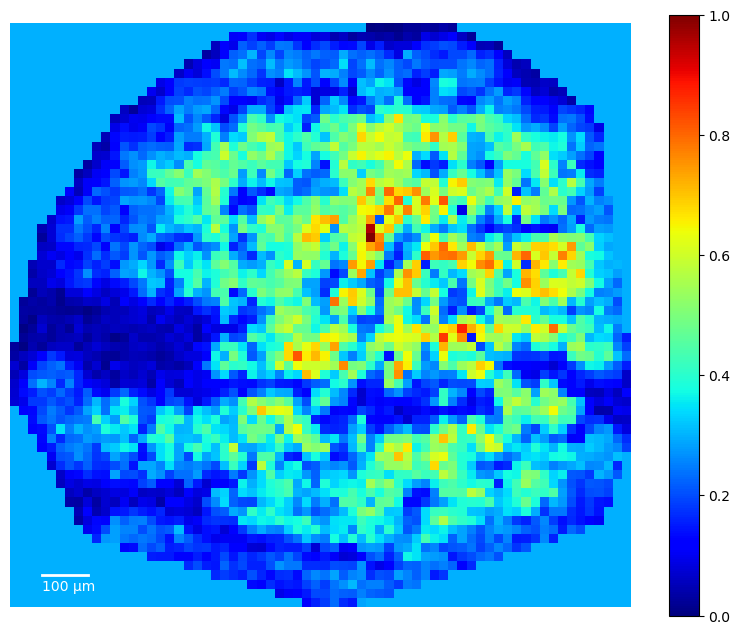

PC1 done


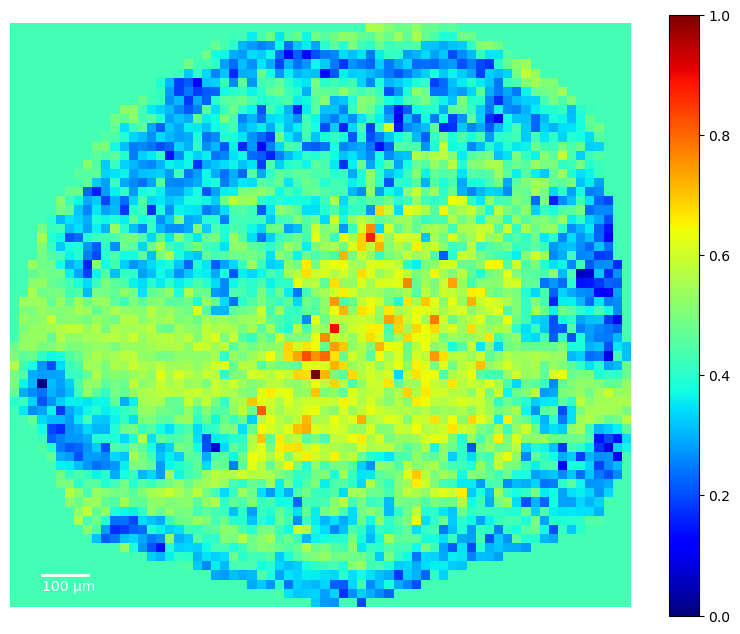

PC2 done


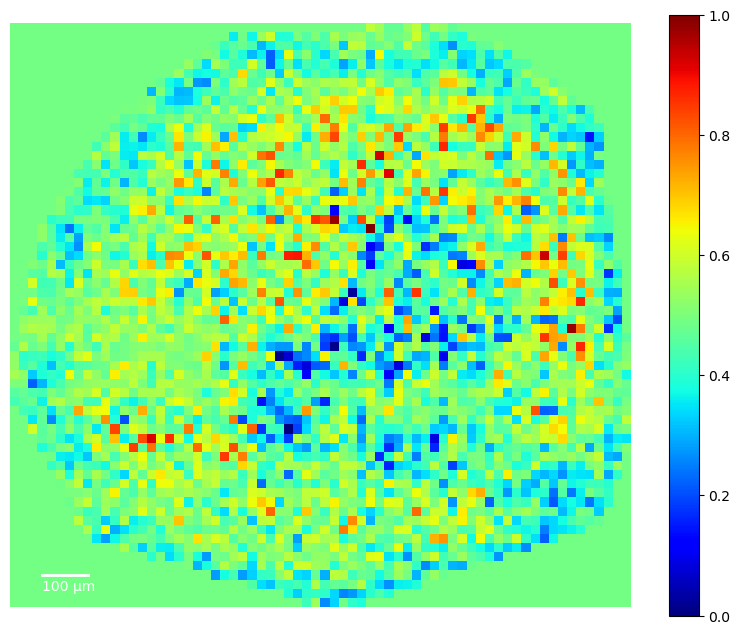

PC3 done


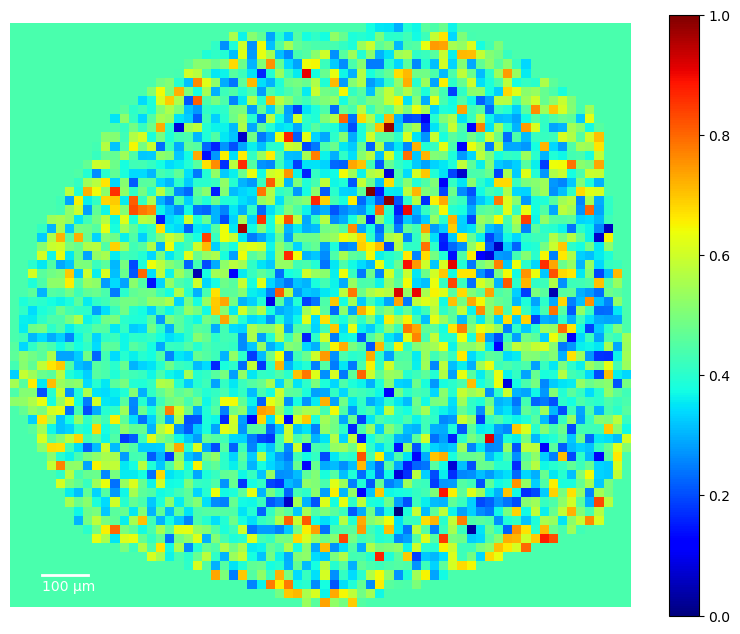

PC4 done


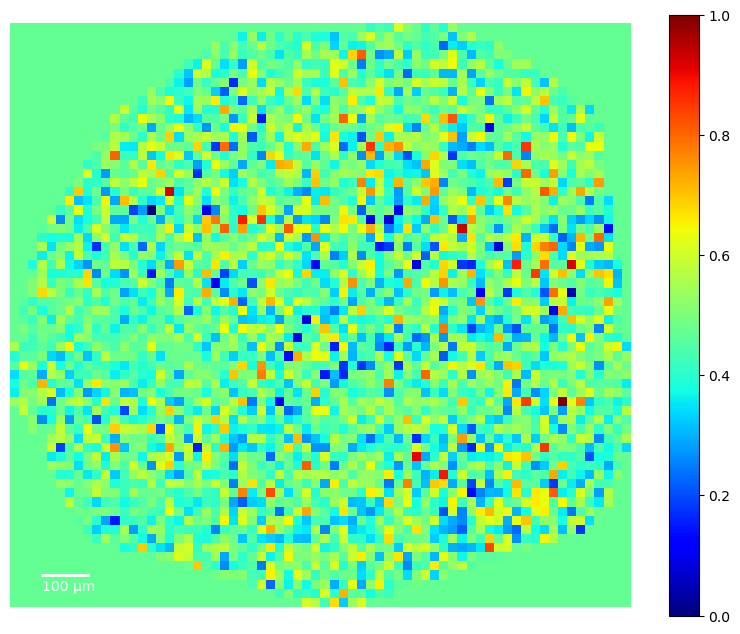

PC5 done


In [254]:
parent_dir = '/mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A2/Cer/230622Spheroids-5-A2-Laser30_left_NA_rawDATA_inner'
file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-A2_left_NA_rawDATA_regionSpots.csv')
feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
main(parent_dir,file_intensity,file_coordinates,feature_list_path)

[0.17060744 0.04757149 0.02764384 0.02290429 0.02137948 0.02123623
 0.02051882 0.01983016 0.01906023 0.01864249 0.01857111 0.01833692
 0.01819228 0.01805169 0.01791073 0.01767867 0.01761395 0.01747973
 0.01717476 0.01691961 0.01684691 0.01661832 0.01652406 0.01605102
 0.01595746 0.01568665 0.01537894 0.01518667 0.01496525 0.0147763
 0.01462195 0.01413834 0.01400183 0.01386834 0.0134142  0.01316355
 0.01301565 0.01289785 0.01258596 0.01202381 0.01196617 0.01127586
 0.01121996 0.01078511 0.01016627 0.00987608 0.00960214 0.00936606
 0.00899035 0.00797967]
0.9602746236438269


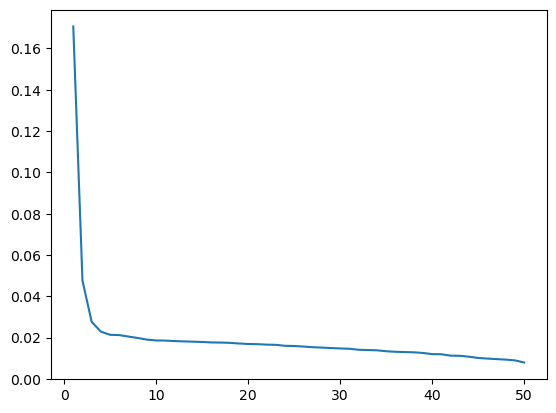

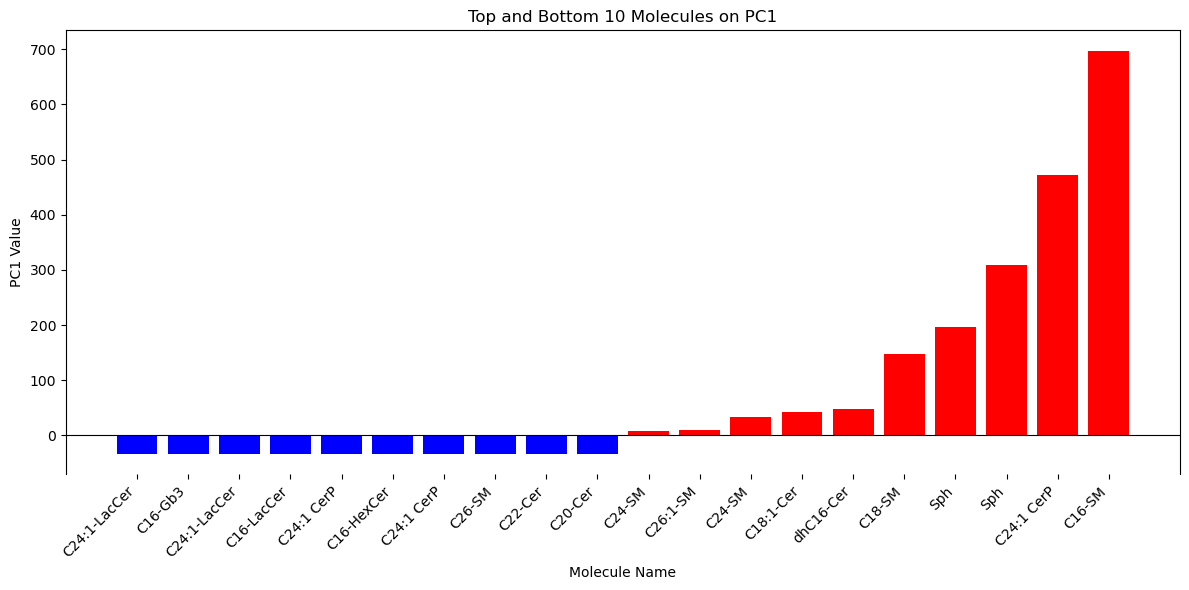

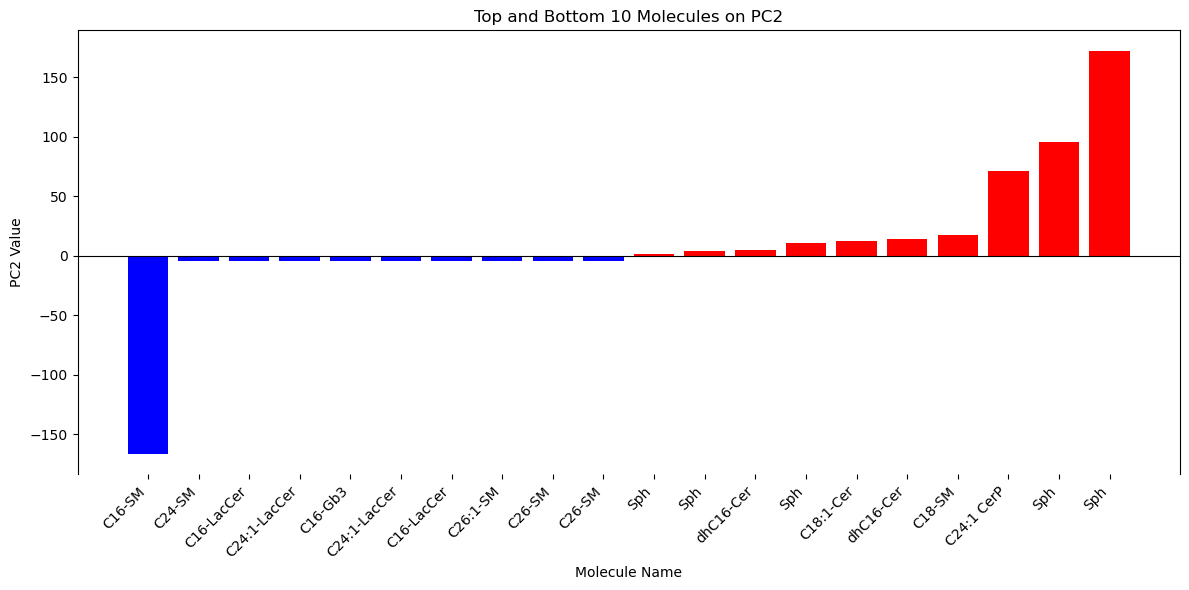

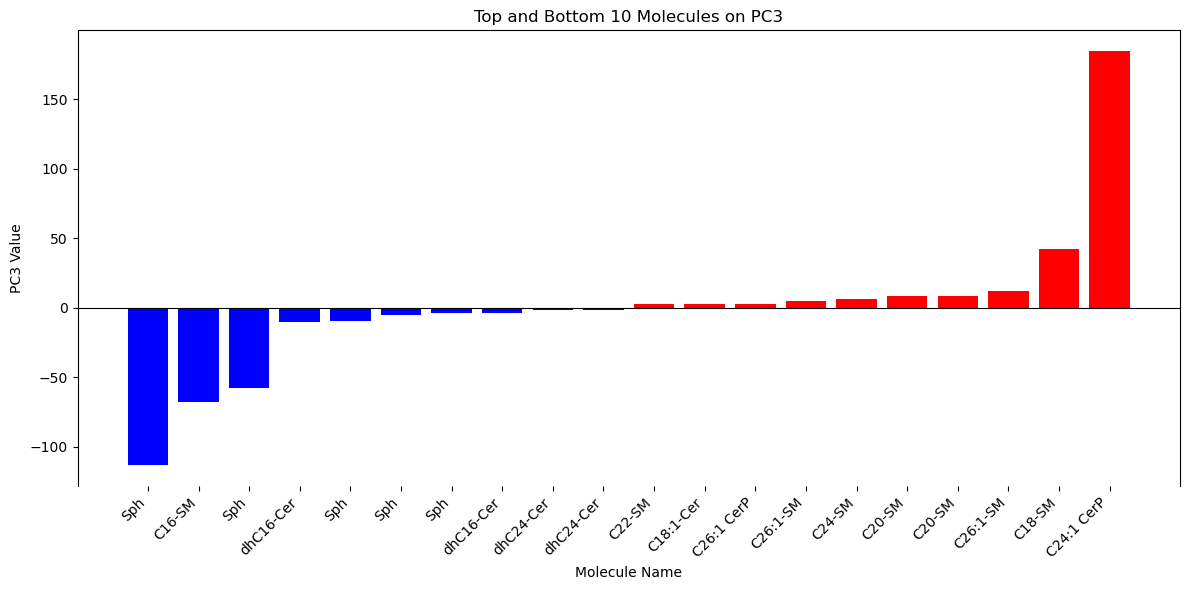

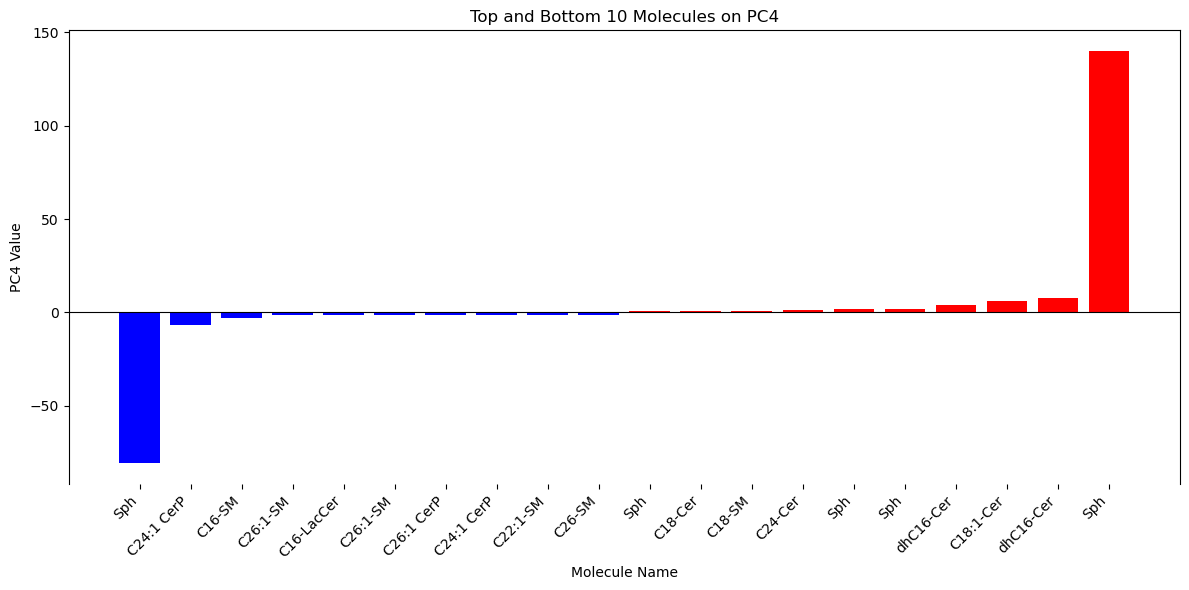

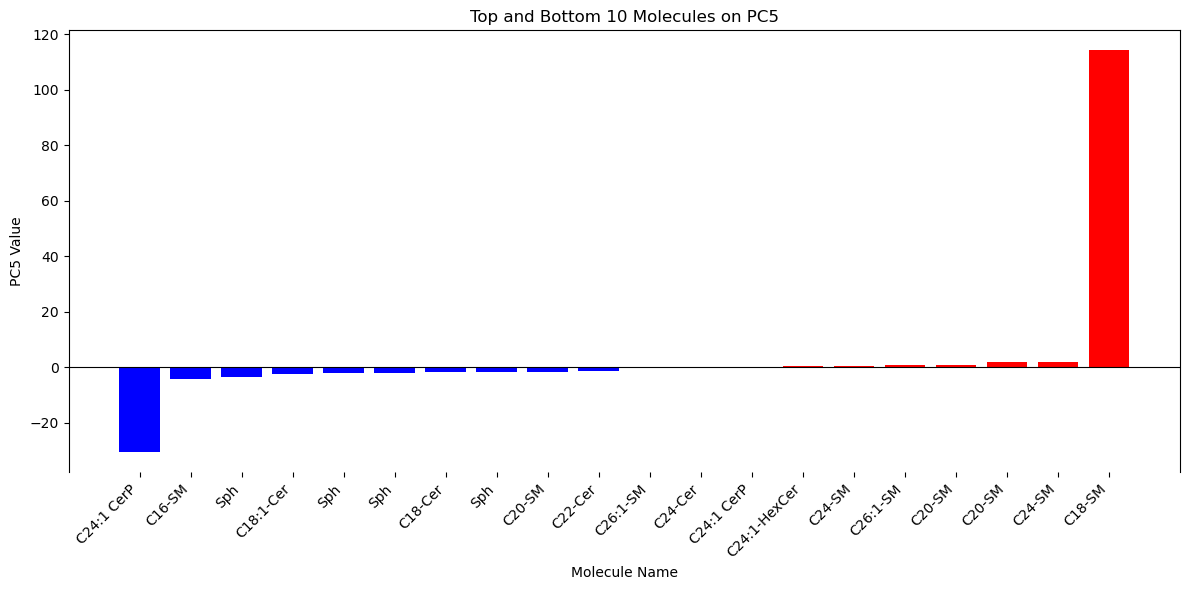

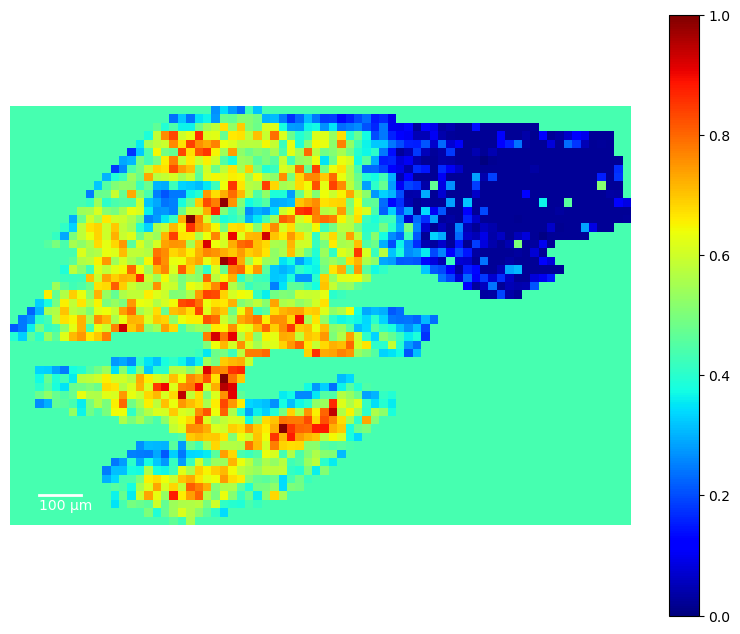

PC1 done


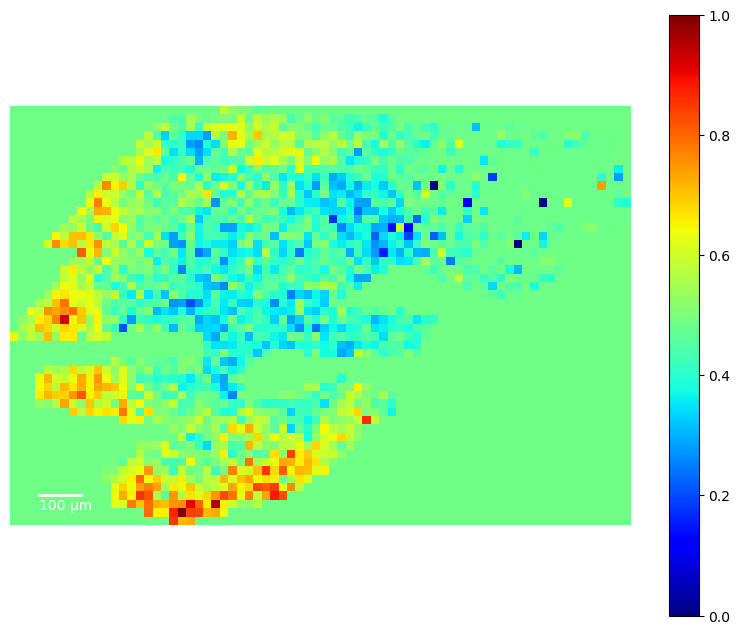

PC2 done


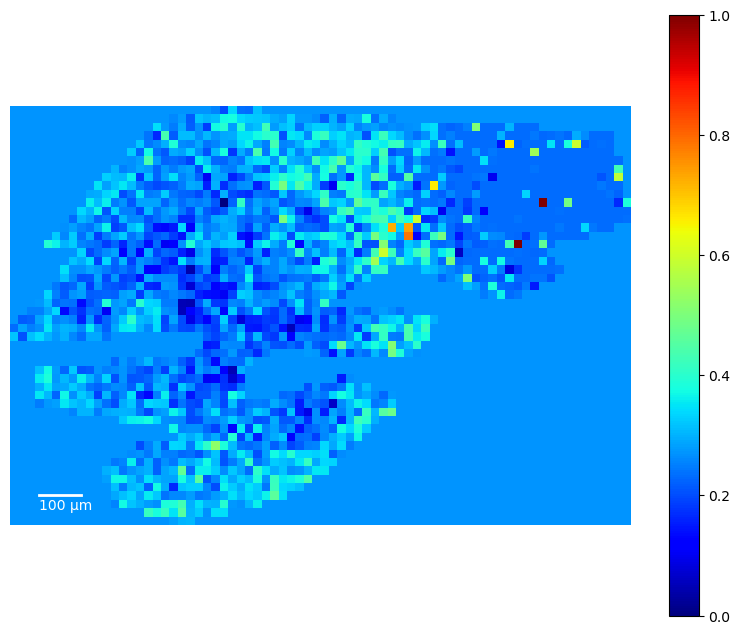

PC3 done


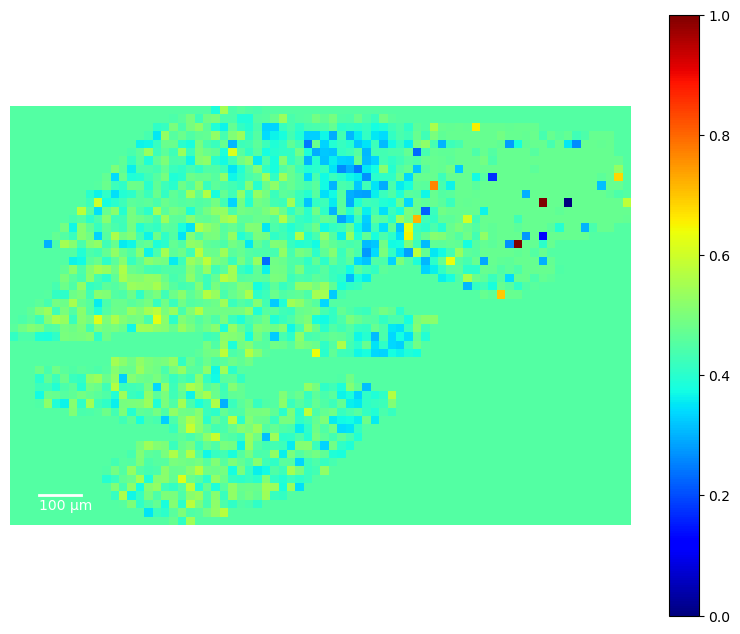

PC4 done


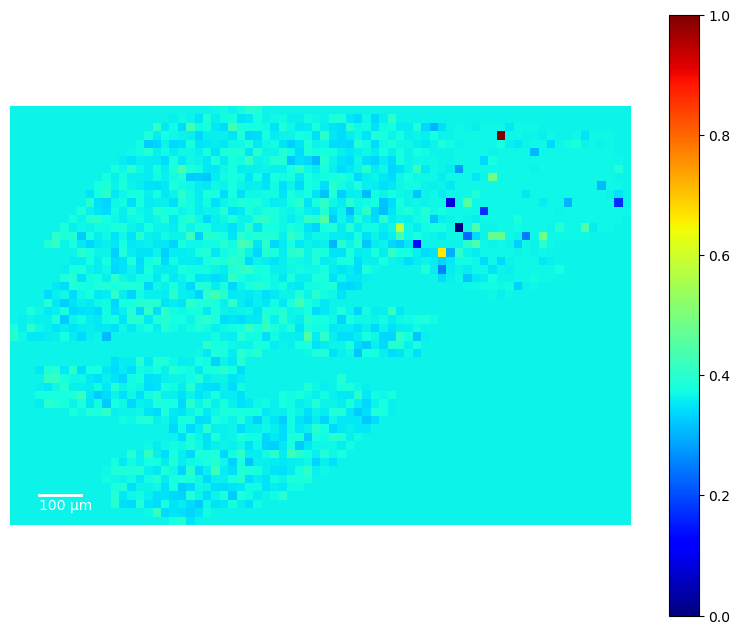

PC5 done


In [255]:
# File paths
parent_dir = '/mnt/data10/shared/yujie/raffat_data/Raw Data/AA/B1/Cer/230622Spheroids-5-B1-Laser30_right_AA_rawDATA_inner'
file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-B1-Laser30_right_AA_rawDATA_regionSpots.csv')
feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
main(parent_dir,file_intensity,file_coordinates,feature_list_path)

[0.22755017 0.04531407 0.02411725 0.02295332 0.02139656 0.02089988
 0.02079774 0.01991329 0.01980169 0.01966755 0.01948608 0.01897464
 0.01859148 0.0183581  0.01814981 0.01770716 0.01749718 0.01718182
 0.01702819 0.01656213 0.01635876 0.01604136 0.01575412 0.01558881
 0.01521455 0.01493411 0.01465829 0.01451161 0.01428871 0.01387292
 0.01347854 0.01336366 0.01316596 0.01283047 0.01252571 0.01183014
 0.01162863 0.01119033 0.0109712  0.01076229 0.01037356 0.00969893
 0.00927515 0.00911648 0.00863505 0.007967   0.00779606 0.00736479
 0.0063287  0.00602451]
0.9774984949287419


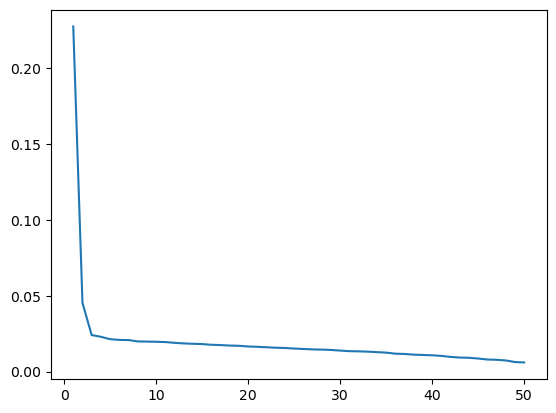

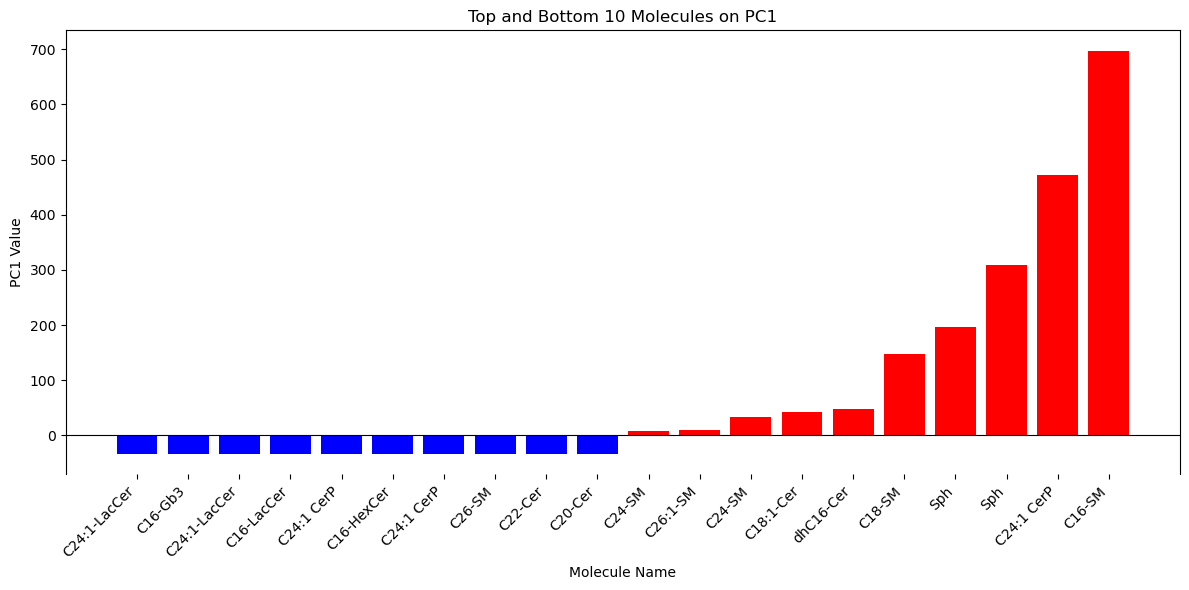

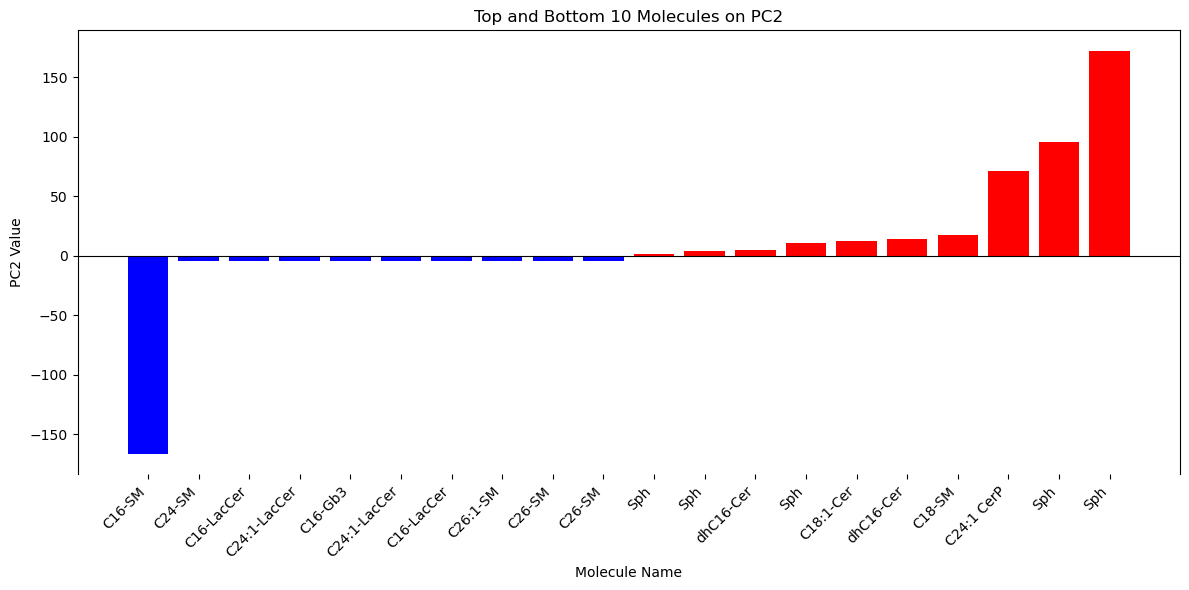

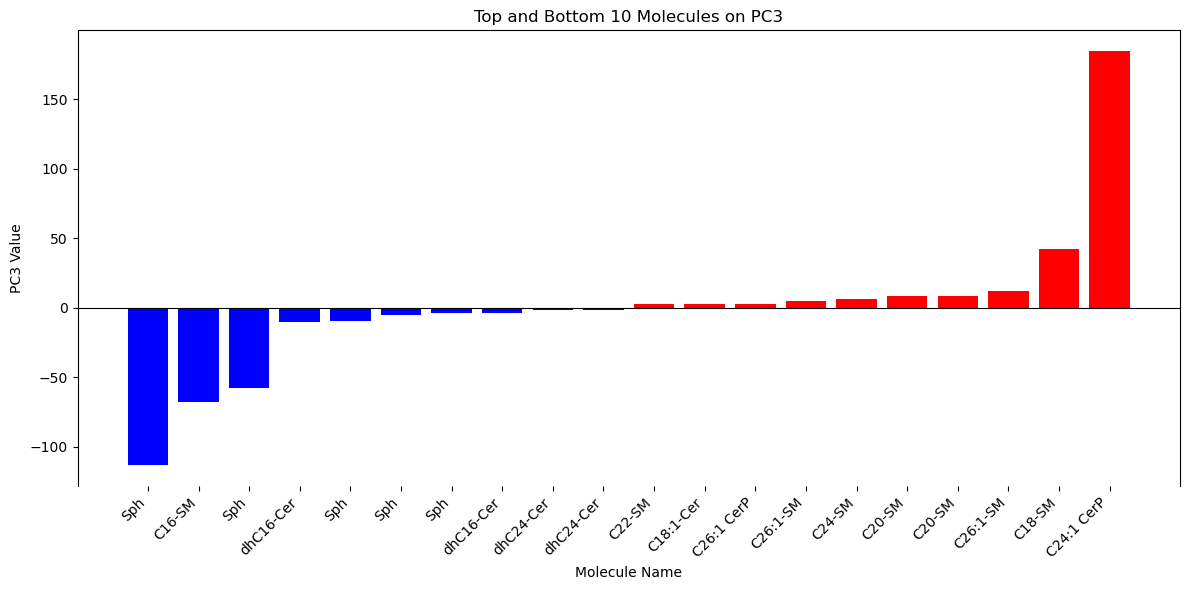

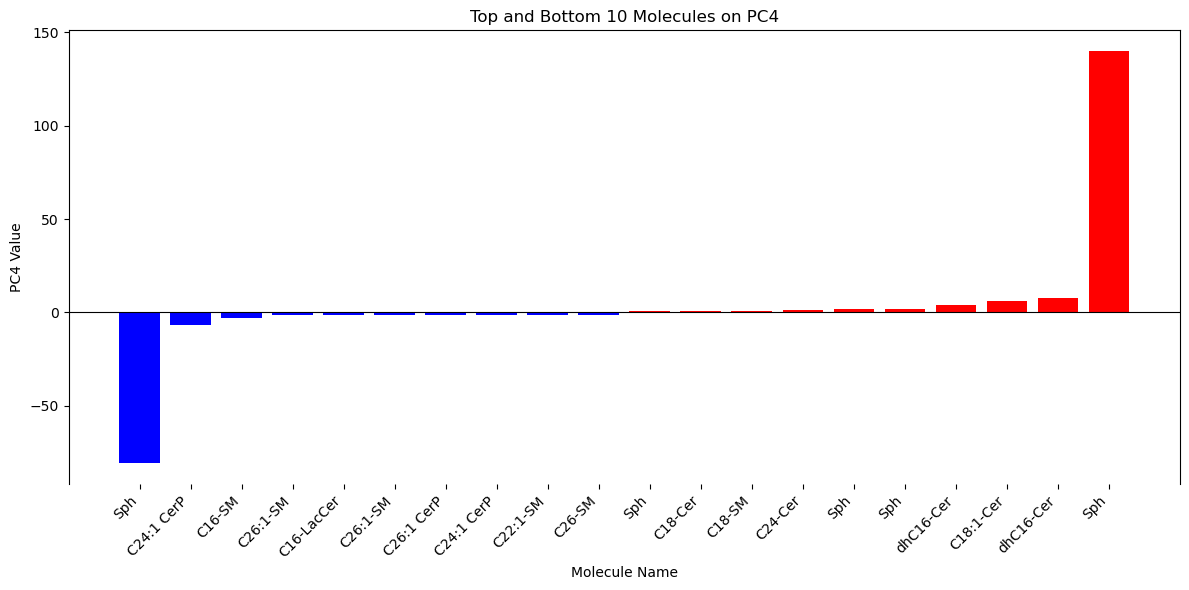

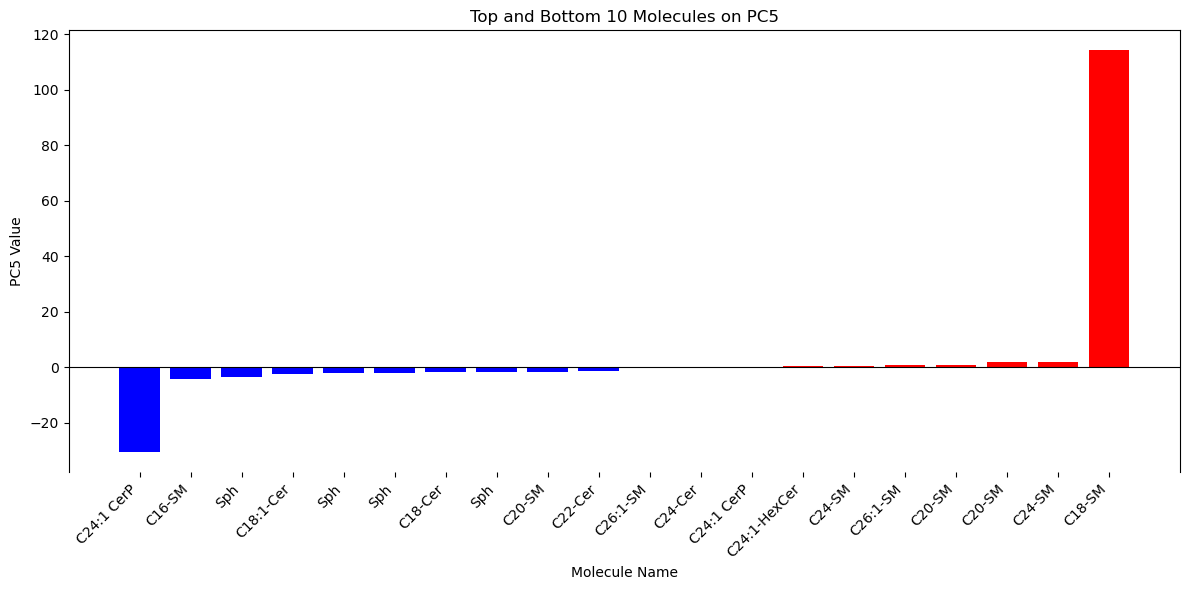

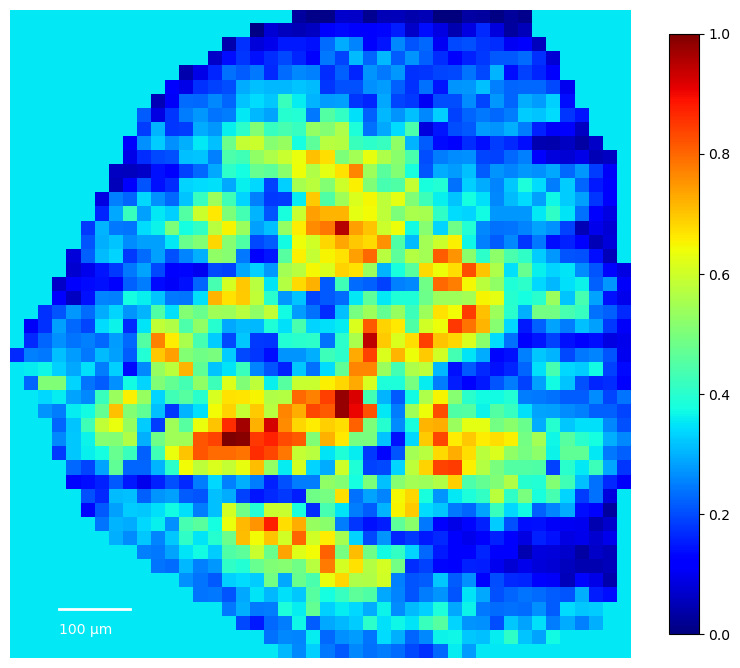

PC1 done


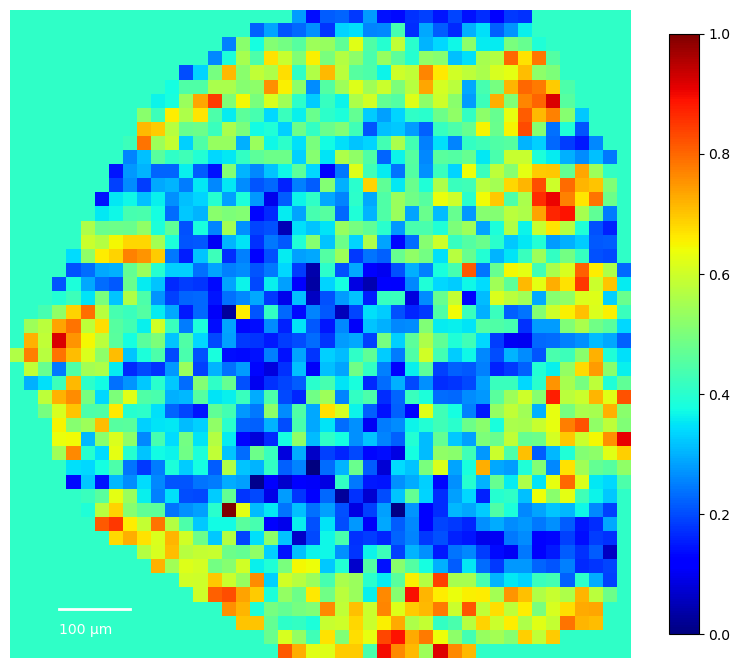

PC2 done


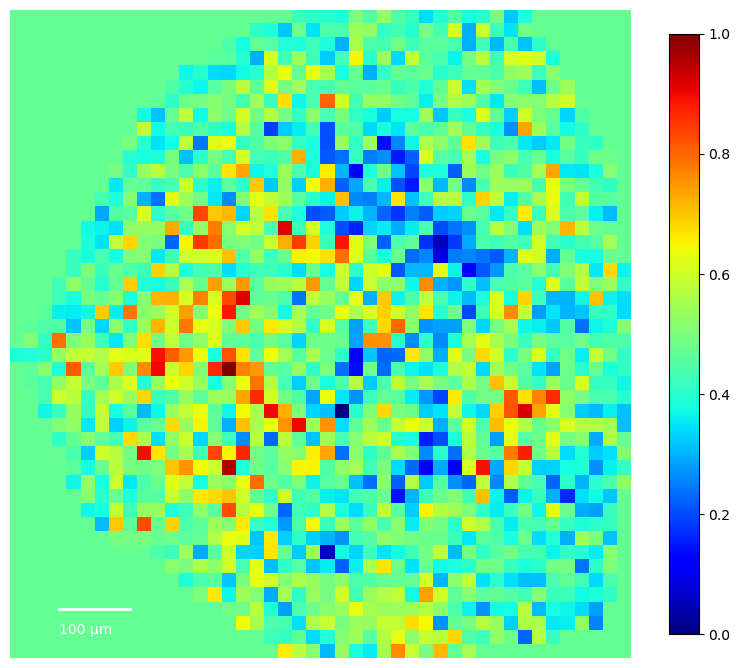

PC3 done


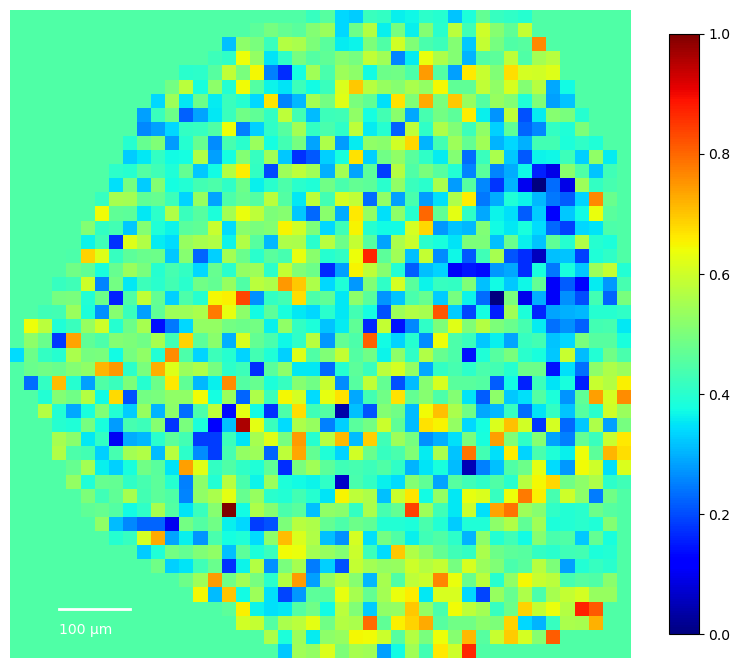

PC4 done


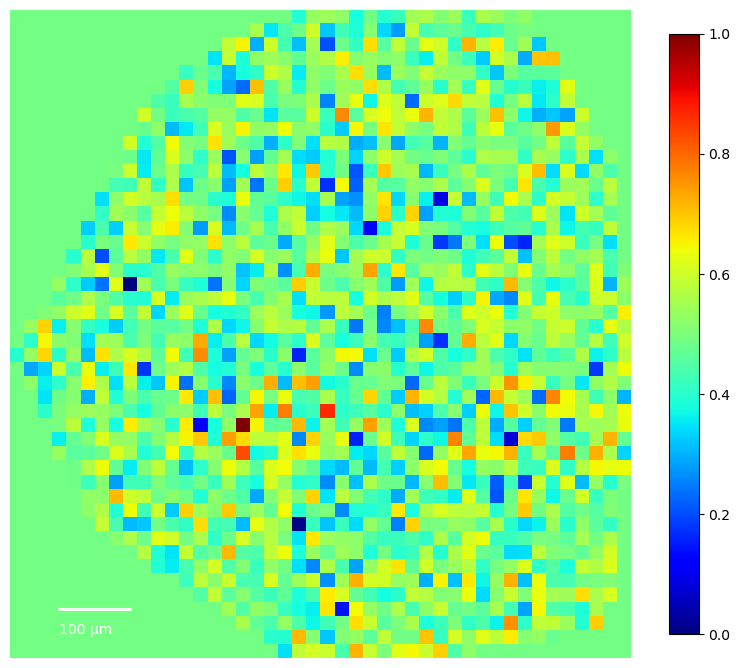

PC5 done


In [256]:
parent_dir = '/mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Cer/230622Spheroids-5-A3-Laser25_left_NA_rawDATA_inner'
file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-A3-Laser25_left_NA_rawDATA_regionSpots.csv')
feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
main(parent_dir,file_intensity,file_coordinates,feature_list_path)

[0.12692587 0.04275883 0.03075794 0.0249416  0.02271103 0.02229158
 0.02139978 0.02125483 0.02077904 0.02047542 0.01983394 0.01967698
 0.01930573 0.01898989 0.01895959 0.01885061 0.01837748 0.01805609
 0.01783006 0.01781079 0.01744604 0.01722583 0.01708843 0.01681248
 0.0166112  0.01645029 0.0161674  0.01603159 0.01572519 0.01545797
 0.01507353 0.01494272 0.01482016 0.01470762 0.01416197 0.01401594
 0.01396329 0.01362378 0.01336981 0.01312735 0.01299804 0.01256459
 0.0123906  0.01194318 0.0117193  0.01137732 0.01136123 0.01051498
 0.0100031  0.0090865 ]
0.9627685012097884


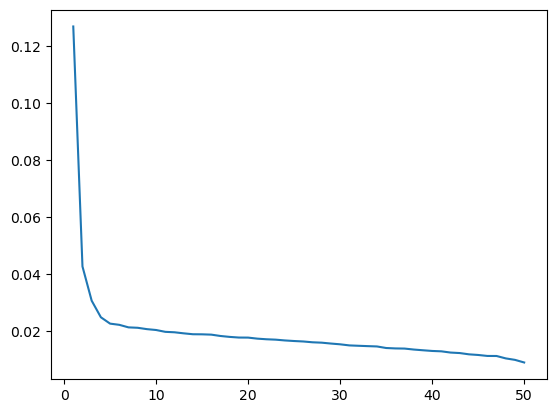

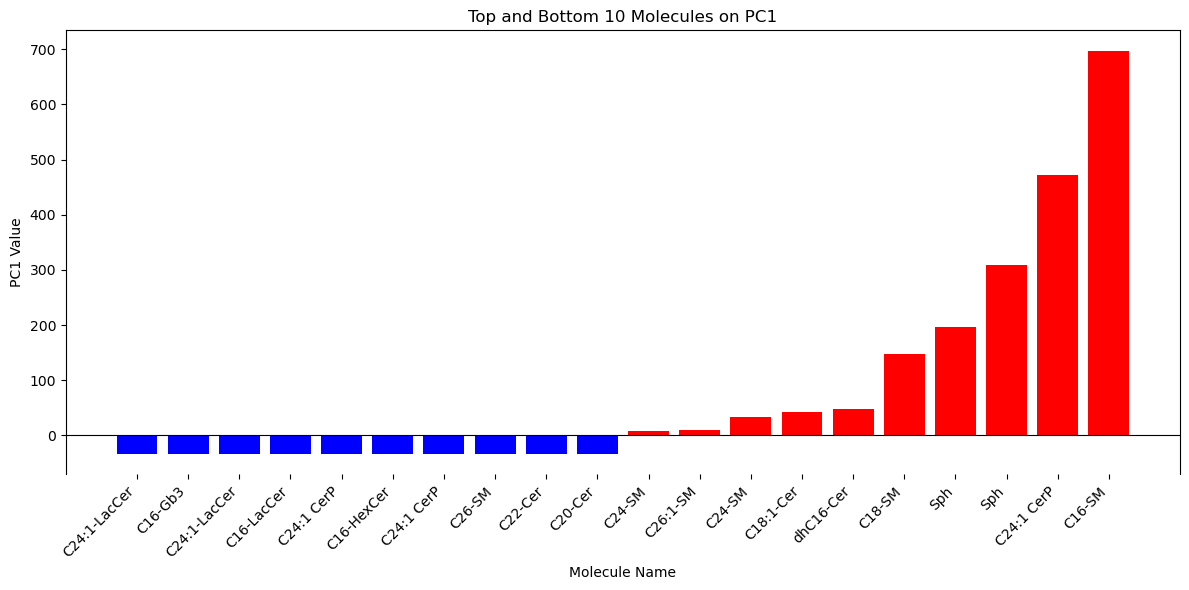

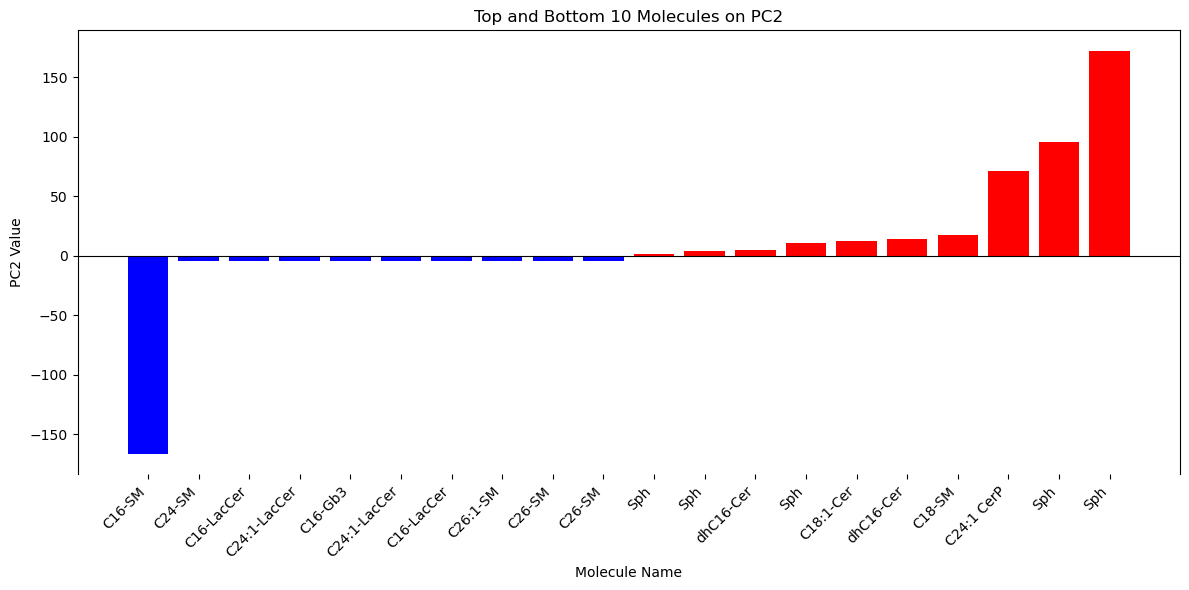

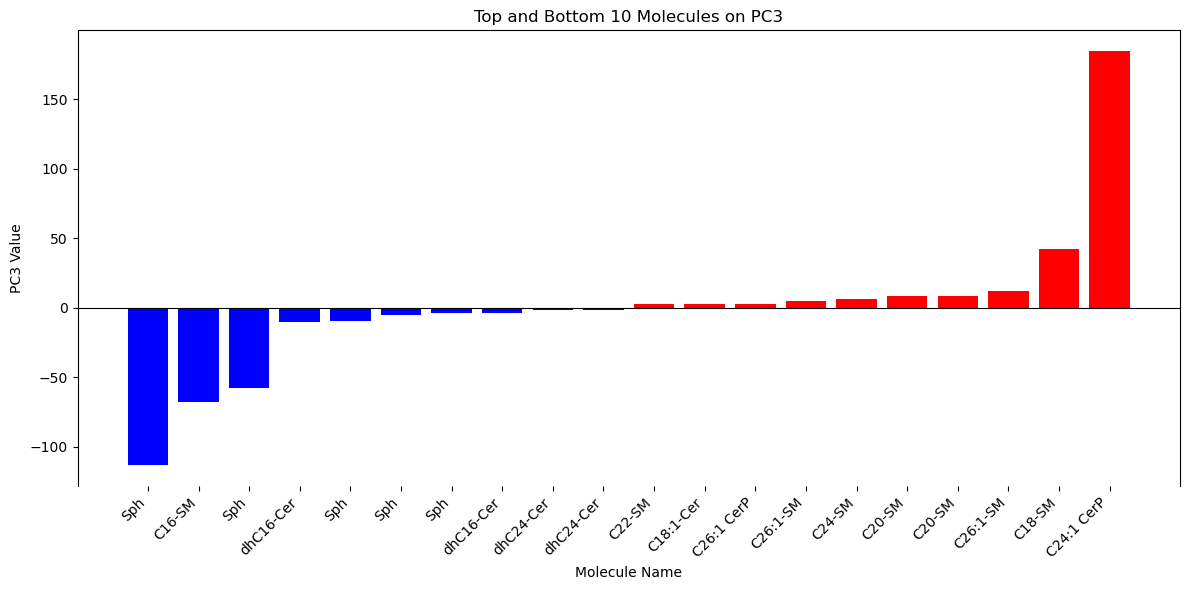

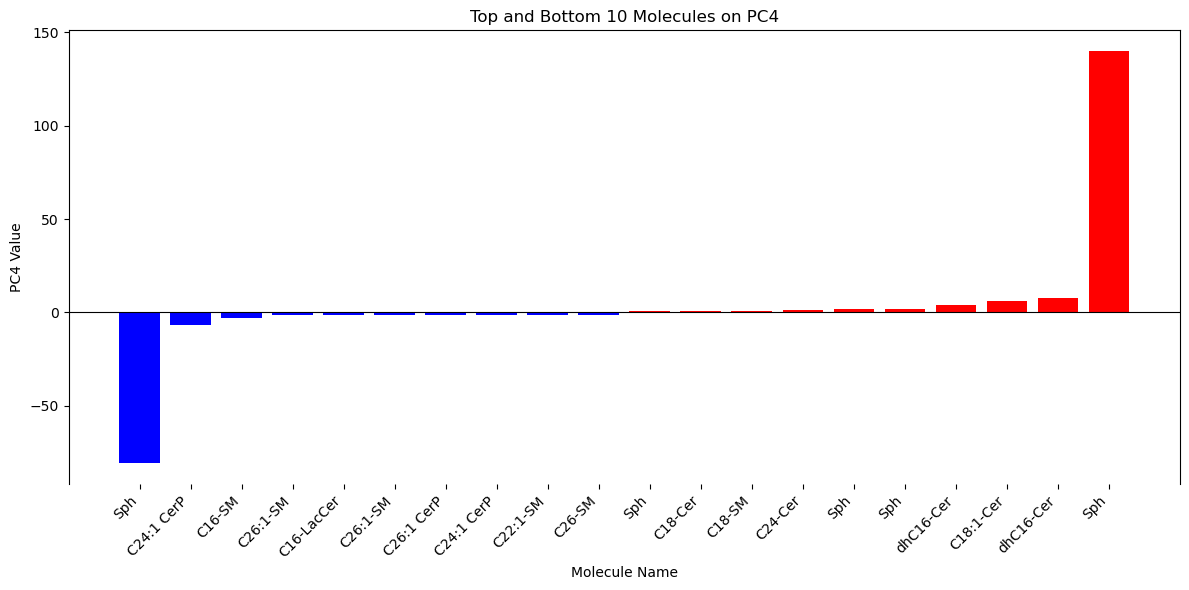

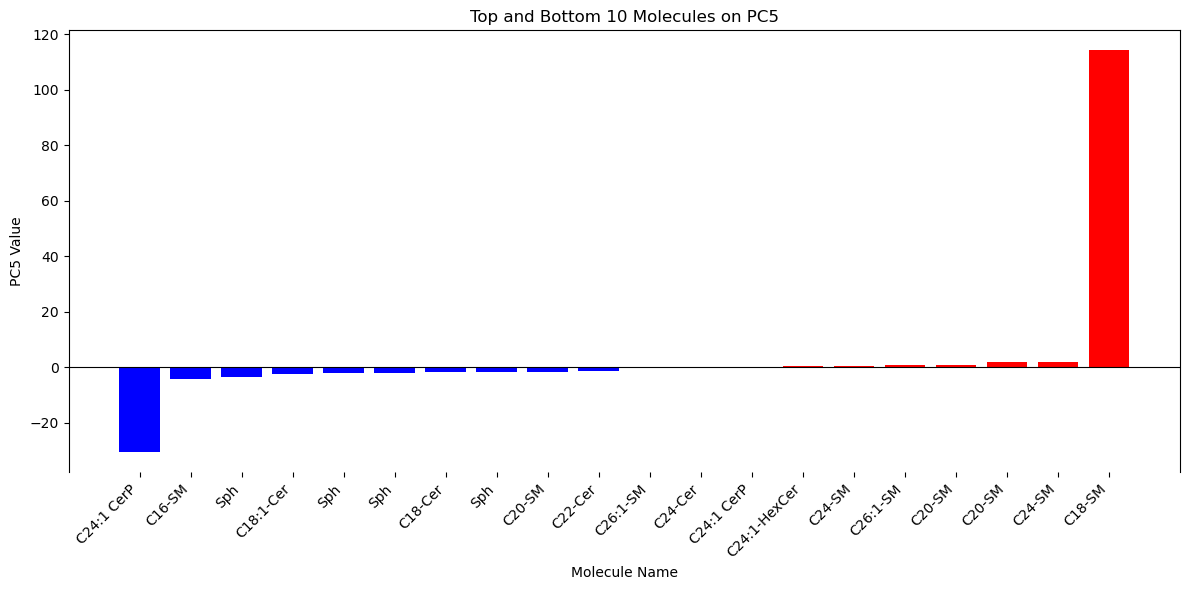

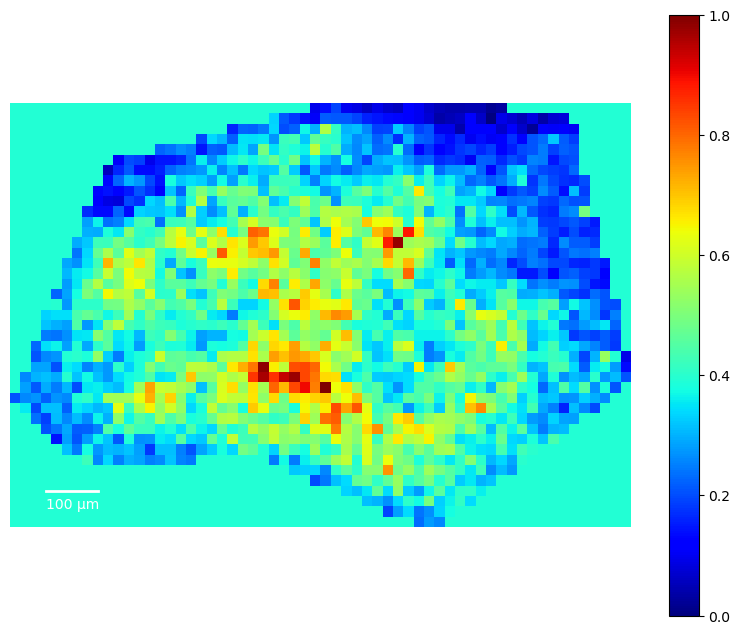

PC1 done


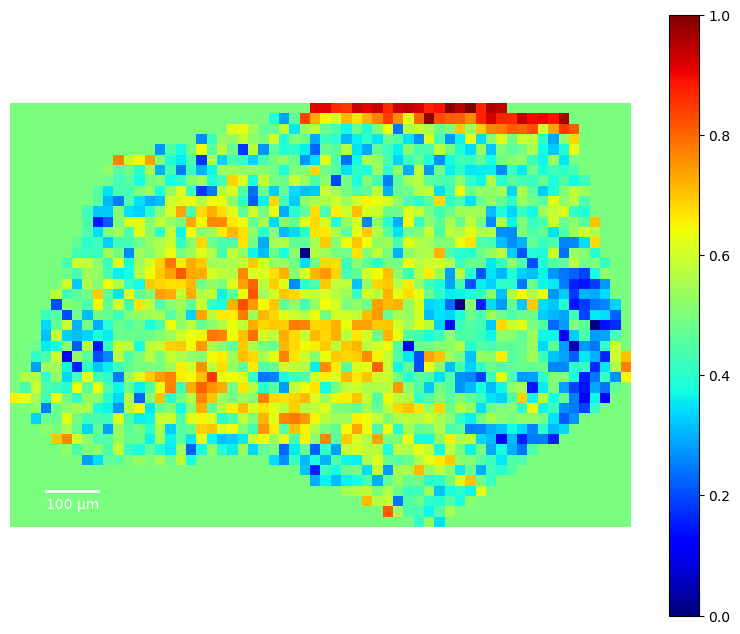

PC2 done


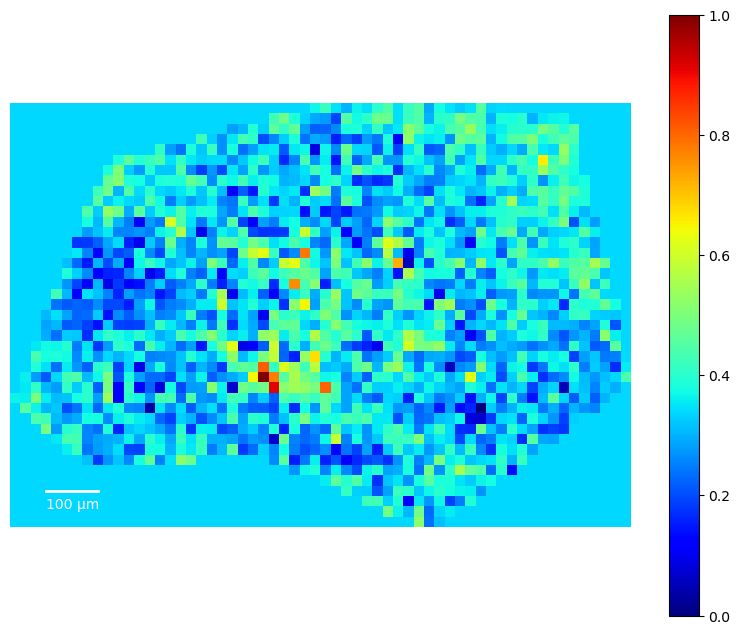

PC3 done


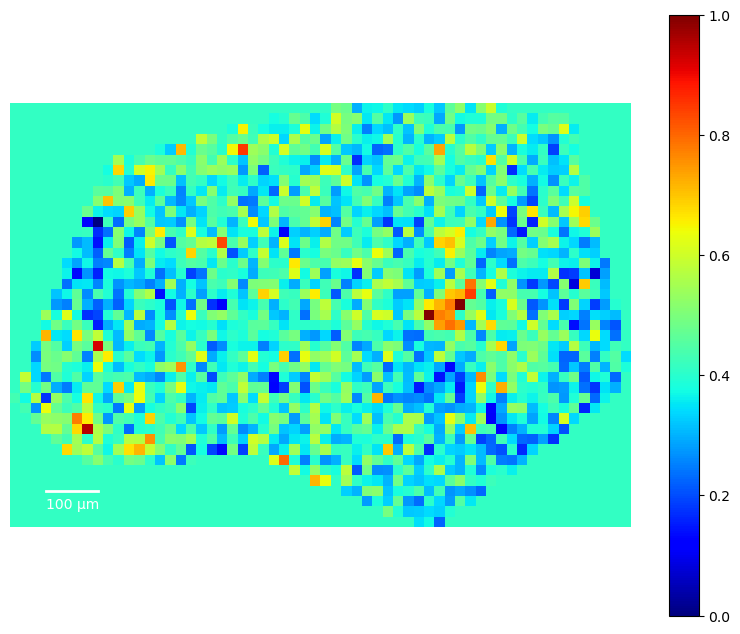

PC4 done


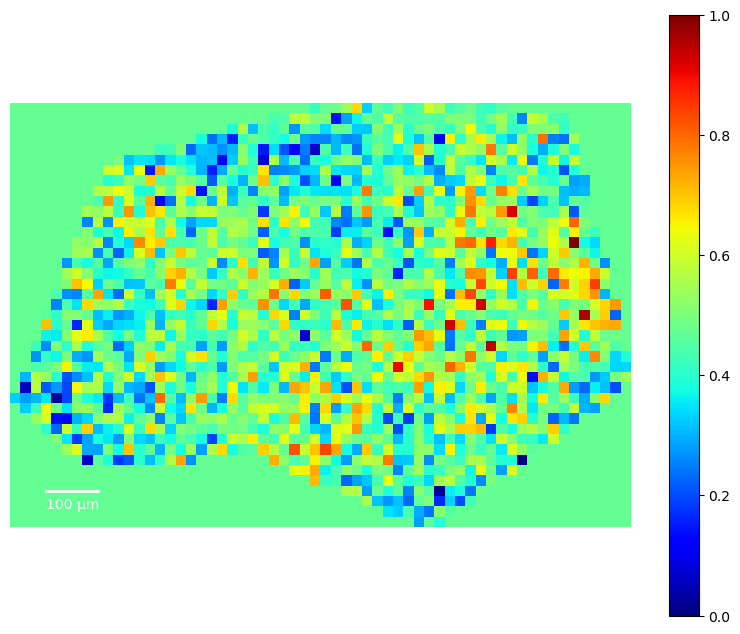

PC5 done


In [257]:
parent_dir = '/mnt/data10/shared/yujie/raffat_data/Raw Data/AA/B2/Cer/230622Spheroids-5-B2-Laser25_right_AA_rawDATA_inner'
file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-B2-Laser25_right_AA_rawDATA_regionSpots.csv')
feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
main(parent_dir,file_intensity,file_coordinates,feature_list_path)

[0.22611381 0.05883184 0.03328421 0.02543142 0.02366739 0.01843671
 0.01787585 0.01749046 0.01722467 0.01709873 0.01705646 0.01665316
 0.01644498 0.01623831 0.01617006 0.01594456 0.0158587  0.01561393
 0.01545434 0.01525325 0.01517865 0.01492579 0.01473881 0.01467224
 0.01454916 0.01442871 0.01417274 0.01408949 0.01401839 0.0138967
 0.01375557 0.01359964 0.01337467 0.01322099 0.01298199 0.01270748
 0.01252982 0.01211662 0.01185687 0.01157082 0.0112686  0.01114626
 0.01062023 0.01053158 0.00988581 0.00941541 0.00896499 0.00711339
 0.00599035 0.00431524]
0.9777798593886784


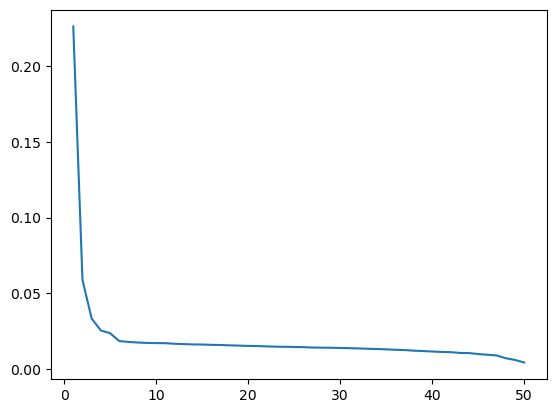

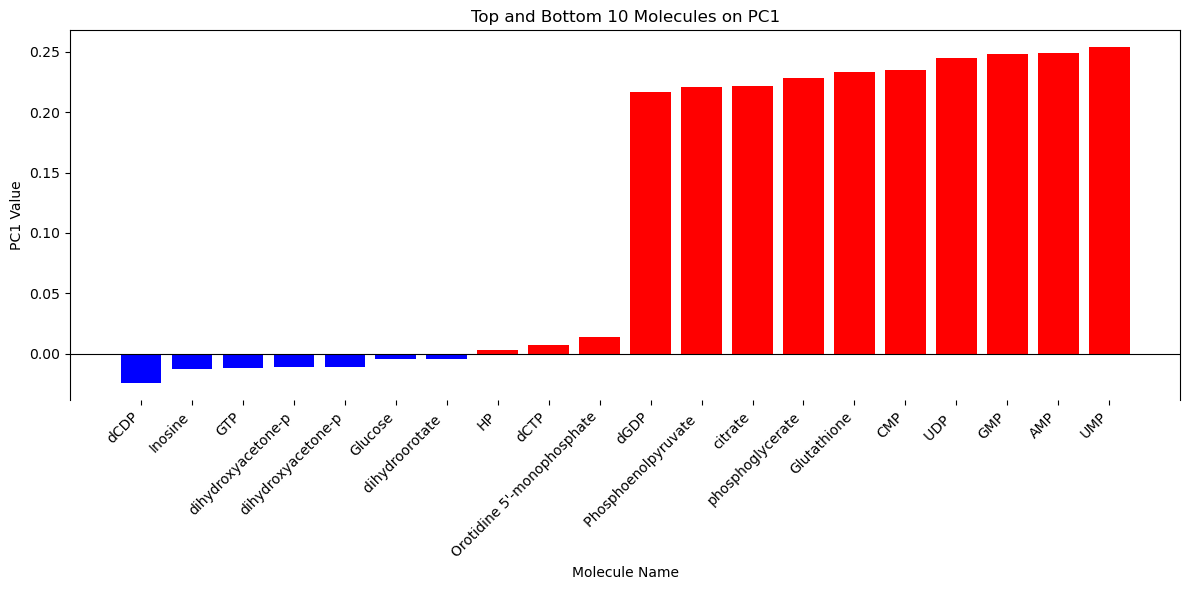

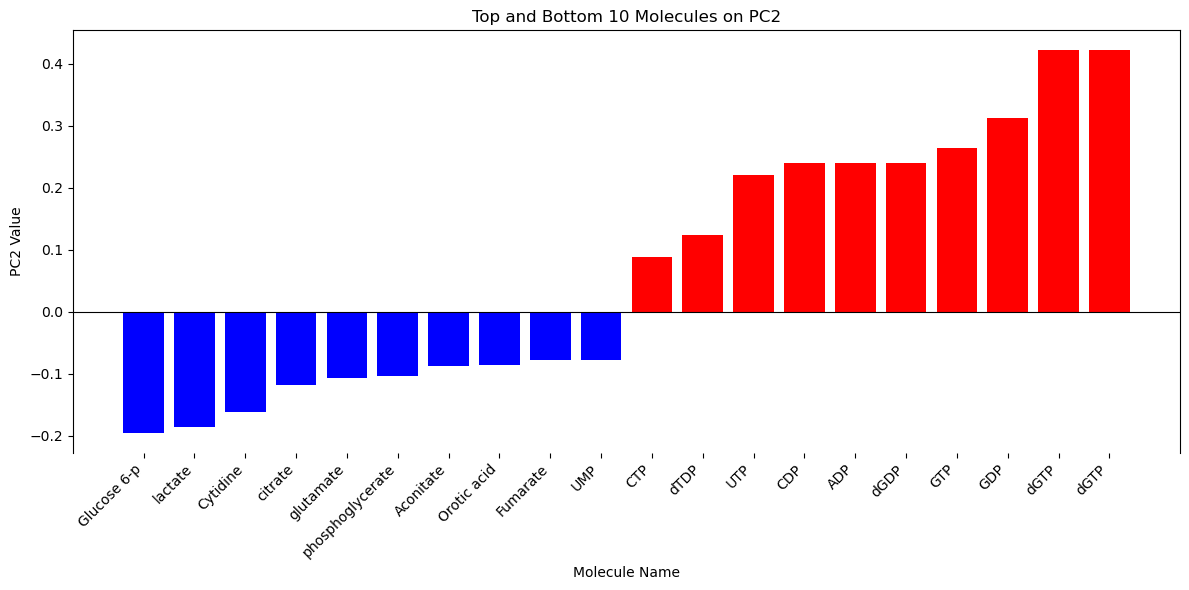

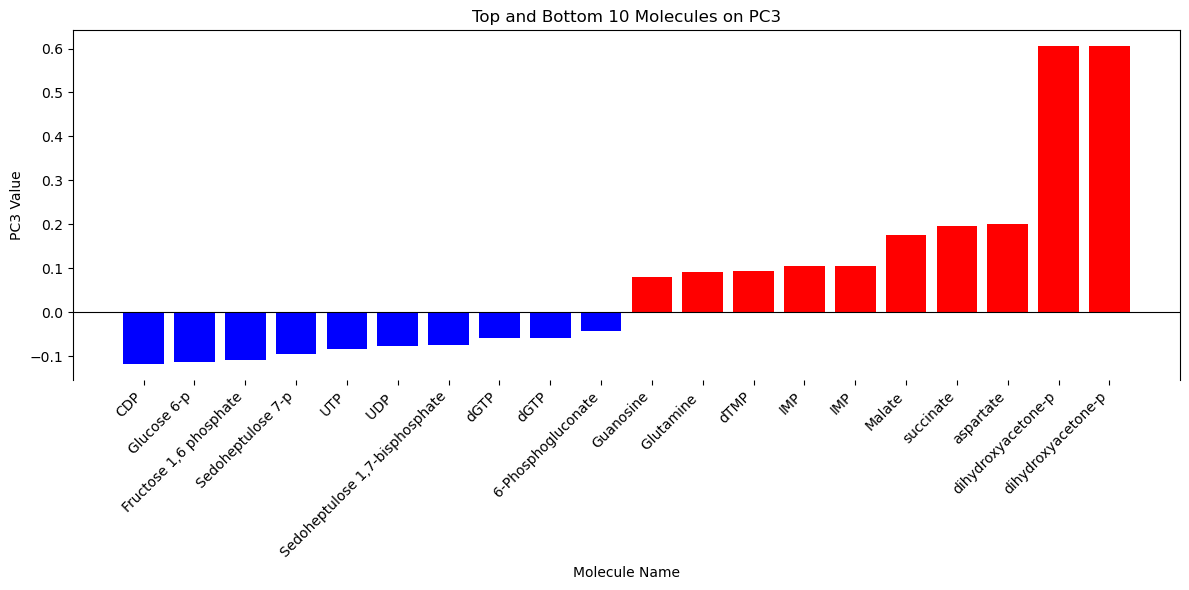

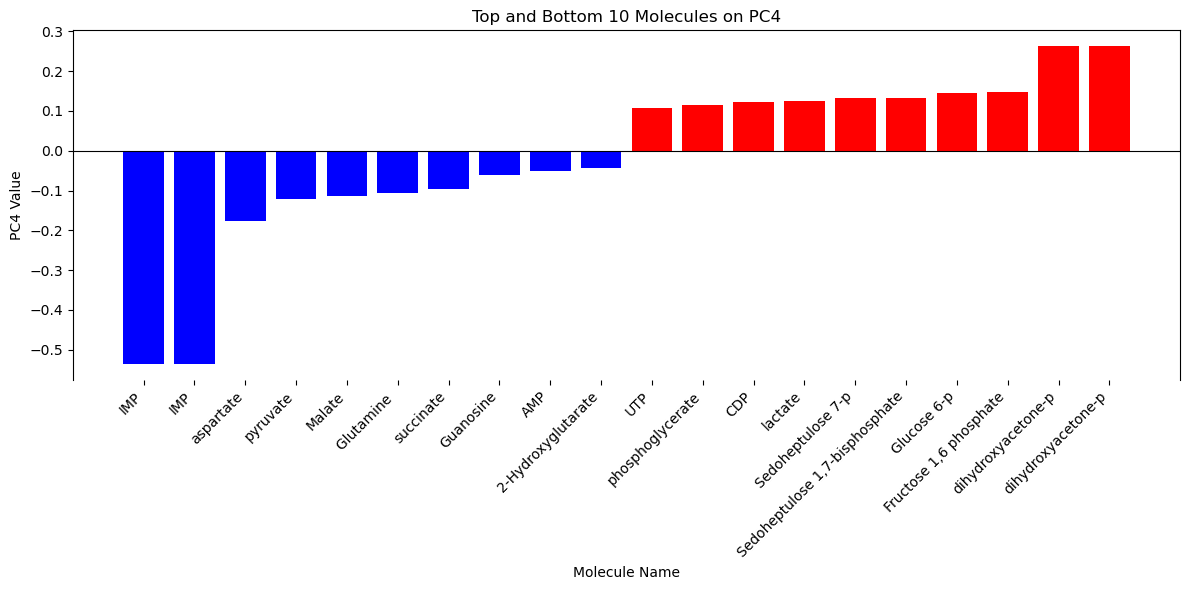

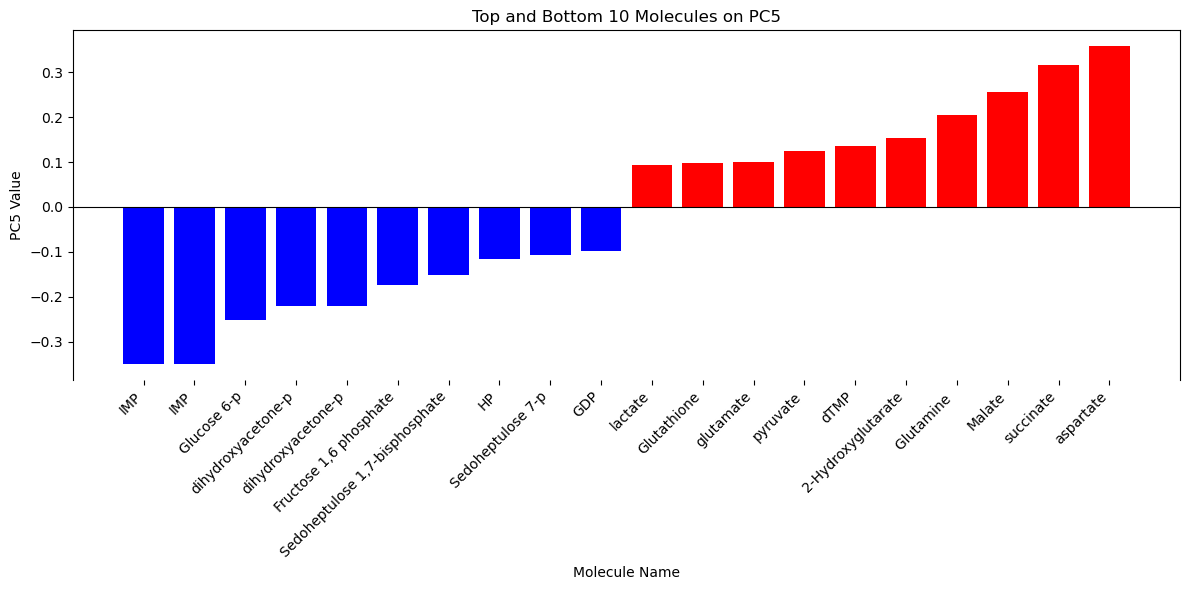

In [7]:
######uni testing
import pandas as pd
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
parent_dir='/mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Met/230703Spheroids-6-A3-Laser60_left_NA_rawDATA_outer'
file_intensity = os.path.join(parent_dir,'outer region-Total Ion Count_col.csv')
file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-A3-Laser60_left_NA_rawDATA_regionSpots.csv')
feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
skip_rows_intensity = 10
skip_rows_coordinates = 8

df_intensity = pd.read_csv(file_intensity, skiprows=skip_rows_intensity, header=0, delimiter=';')

df_feature_list = pd.read_csv(feature_list_path, delimiter=';', skiprows=8)
df_coordinates = pd.read_csv(file_coordinates, skiprows=8, delimiter=';')
###########PCA
X = df_intensity.iloc[:, 1:]  

X = X.T#m*n,2000*57
#print(X.shape)

# Standardizing the features(per molecule)

X_standardized = StandardScaler().fit_transform(X)

# Performing PCA
pca = PCA(n_components=50)
principal_components = pca.fit_transform(X_standardized)
#m*p,2000*8

# Creating a DataFrame with the principal components
pc_intensities = pd.DataFrame(data=principal_components,
                      columns=[f'PC{i}' for i in range(1,51)])




# Concatenating the molecule names ('m/z') with the principal components
#Ax=b, x of dimension n*p
weight_df = pd.DataFrame(data=np.linalg.pinv(X_standardized).dot(principal_components),
                      columns=[f'PC{i}' for i in range(1,51)])
weight_df = pd.concat([df_intensity['m/z'], weight_df], axis=1)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
plt.plot(range(1,51),pca.explained_variance_ratio_)


plot_bar(weight_df,df_feature_list,col='PC1',num=10)
plot_bar(weight_df,df_feature_list,col='PC2',num=10)
plot_bar(weight_df,df_feature_list,col='PC3',num=10)
plot_bar(weight_df,df_feature_list,col='PC4',num=10)
plot_bar(weight_df,df_feature_list,col='PC5',num=10)